In [1]:
# import sys
# sys.path.append('/home/nicholasjesperson/Documents/School/Comp4780/Data_Augmentation/Data Augmentation/paper/AugmenTRAJ')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, accuracy_score, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import DecisionBoundaryDisplay

from ptrail.core.Datasets import Datasets
from ptrail.preprocessing.filters import Filters
from ptrail.core.TrajectoryDF import PTRAILDataFrame
from ptrail.preprocessing.statistics import Statistics

from src.augmentation.augment import Augmentation
from src.selection.select import Selection
from src.utils.alter import Alter

from matplotlib.colors import ListedColormap
from random import Random

In [3]:
def trajectoryAugumentationProcedure(trajs, seed, n, k, pradius, class_name, selection, augment):
    myRandom = Random(seed * (n * k * pradius))

    # Select the trajectories and remove duplicates from original dataset.
    if selection == 'random':
        splits = Selection.select_randomly(trajs, myRandom, .2)
    elif selection == 'fewest':
        splits = Selection.select_traj_with_fewest(trajs, myRandom, .2)
    elif selection == 'class':
        splits = Selection.select_fewest_class(trajs, class_name, myRandom, .2)
    else:
        splits = Selection.select_representative_trajectories(trajs, class_name)
    paramTestingDataSet = Filters.remove_duplicates(dataframe=trajs)

    trainDataParm = paramTestingDataSet.loc[paramTestingDataSet.traj_id.isin(splits["train"]) == True].dropna()
    testDataParm = paramTestingDataSet.loc[paramTestingDataSet.traj_id.isin(splits["test"]) == True].dropna()
    testData = PTRAILDataFrame(data_set=testDataParm,
                               latitude='lat',
                               longitude='lon',
                               datetime='DateTime',
                               traj_id='traj_id')


    noiseTraj = trainDataParm.traj_id.unique()
    sampledTraj = myRandom.choices(sorted(noiseTraj), k=math.floor(n * len(noiseTraj)))
    for traj in sampledTraj:
        trajToChange = trainDataParm.loc[trainDataParm.traj_id == traj]

        #Trajectory must be changed
        if augment == 'on':
            trajChanged = Augmentation.augment_trajectories_with_randomly_generated_points(trajToChange, pradius,
                                                                                         k, 100, myRandom, 'on')
        elif augment == 'in':
            trajChanged = Augmentation.augment_trajectories_with_randomly_generated_points(trajToChange, pradius,
                                                                                          k, 100, myRandom, 'in')
        else:
            trajChanged = Augmentation.augment_trajectories_with_interpolation(trajToChange, 3600*4, 'linear')
        trainDataParm = pd.concat([trainDataParm, trajChanged], ignore_index = True)

    trainDataNoise = PTRAILDataFrame(data_set=trainDataParm,
                                            datetime='DateTime',
                                            traj_id='traj_id',
                                            latitude='lat',
                                            longitude='lon')

    statsTestParm = Statistics.generate_kinematic_stats(dataframe=testData, target_col_name=class_name)
    pivotedStatsTestParm = Statistics.pivot_stats_df(dataframe=statsTestParm, target_col_name=class_name)
    testData = pivotedStatsTestParm.loc[:,~pivotedStatsTestParm.columns.duplicated()]

    statsTrainNoiseParm = Statistics.generate_kinematic_stats(dataframe=trainDataNoise, target_col_name=class_name)
    pivotedStatsTrainNoiseParm = Statistics.pivot_stats_df(dataframe=statsTrainNoiseParm, target_col_name=class_name)
    pivotedStatsTrainNoise = pivotedStatsTrainNoiseParm.loc[:, ~pivotedStatsTrainNoiseParm.columns.duplicated()]
    trainDataNoise=pivotedStatsTrainNoise.dropna()

    return testData, trainDataNoise

In [4]:
# Load the traffic dataset.
original_traffic = Datasets.load_traffic_data()
stats = Statistics.generate_kinematic_stats(original_traffic, "traffic_lane")
pivoted_original_stats = Statistics.pivot_stats_df(stats, "traffic_lane")

# Read the results from the file.
all_traffic_results = pd.read_csv('./FinalHurricaneResults.csv', sep=',', header=None)
all_traffic_results.columns = ['seed', 'n_val', 'k_val', 'rad_val', 'traj_selection_method', 'augmentation_method', 'f1_score']
all_traffic_results.sort_values(by='f1_score', ascending=False, ignore_index=True, inplace=True)
best_traffic_result_set = all_traffic_results.iloc[0, :].tolist()

------------------------ Dataset Facts ------------------------------

Number of unique Trajectories in the data: 125
Number of points in the data: 44905
Dataset time range: 0 days 00:00:59.900000
Datatype of the DataFrame: <class 'ptrail.core.TrajectoryDF.PTRAILDataFrame'>
Dataset Bounding Box: (34.7107417, 135.4640652, 34.7156517, 135.4702002)

---------------------------------------------------------------------


In [5]:
# Best result augmentation.
testData, trainingData = trajectoryAugumentationProcedure(original_traffic, best_traffic_result_set[0],
                                                          best_traffic_result_set[1], best_traffic_result_set[2],
                                                          best_traffic_result_set[3], 'traffic_lane',
                                                          best_traffic_result_set[4], best_traffic_result_set[5])

# Select fewest class augmentation.
fewestTest, fewestTraining = trajectoryAugumentationProcedure(original_traffic, best_traffic_result_set[0],
                                                              best_traffic_result_set[1], best_traffic_result_set[2],
                                                              best_traffic_result_set[3], 'traffic_lane',
                                                              'class', 'interpolation')

In [7]:
# Calculate the f1-score for the original dataset.
mod, testData, trainingData = RandomForestClassifier(), testData.dropna(), trainingData.dropna()
fewestTraining, fewestTest = fewestTraining.dropna(), fewestTest.dropna()
pivoted_original_stats = pivoted_original_stats.dropna()
X_trn, X_tst, y_trn, y_tst = train_test_split(pivoted_original_stats.drop(columns=['traffic_lane']),
                                              pivoted_original_stats['traffic_lane'], test_size=0.2, random_state=1)
mod.fit(X_trn, y_trn)
og_score = f1_score(y_tst, mod.predict(X_tst), average="weighted")

# Calculate the f1-score for the augmented dataset.
mod1 = RandomForestClassifier()
mod1.fit(trainingData.drop(columns=['traffic_lane']), trainingData['traffic_lane'])
aug_score = f1_score(testData['traffic_lane'], mod1.predict(testData.drop(columns=['traffic_lane'])), average='weighted')

# Calculate the f1-score for fewest class augmented dataset.
mod2 = RandomForestClassifier()
mod2.fit(fewestTraining.drop(columns=['traffic_lane']), fewestTraining['traffic_lane'])
few_score = f1_score(fewestTest['traffic_lane'], mod2.predict(fewestTest.drop(columns=['traffic_lane'])), average='weighted')

Text(0.5, 1.0, 'Augmented Dataset Grid (using fewest select)\nF1 Score (Without PCA): 0.9565217391304348')

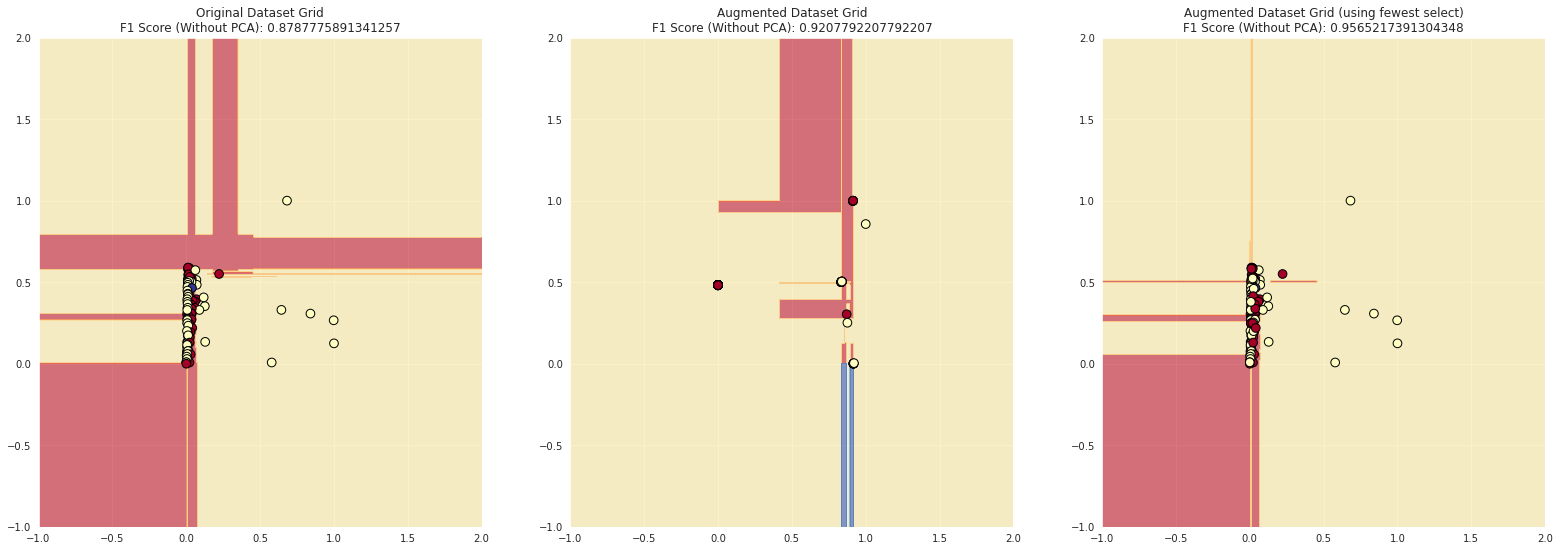

In [11]:
# ------------------------------- Original Dataset Decision Boundaries ----------------------------------------- #

model = RandomForestClassifier()
pca1 = PCA(n_components=2)
scaler = MinMaxScaler(feature_range=(0, 1))
X, Y = pivoted_original_stats.drop(columns=['traffic_lane']), pivoted_original_stats['traffic_lane'].tolist()
Y = [hash(x) for x in Y]
pca_x = scaler.fit_transform(pca1.fit_transform(X))

X_train, X_test, y_train, y_test = train_test_split(pca_x, Y, test_size=0.2, random_state=1)
model.fit(X_train, y_train)

fig, ax = plt.subplots(1, 3, figsize=(27, 9))
ax = ax.flatten()
cmap = plt.cm.RdYlBu
disp = DecisionBoundaryDisplay.from_estimator(model, pca_x, response_method='predict',
                                              cmap=cmap, grid_resolution=1000, alpha=0.6, ax=ax[0])
disp.ax_.scatter(pca_x[:, 0], pca_x[:, 1], c=Y, edgecolor="k", cmap=cmap, alpha=1, s=75)
disp.ax_.set_title(f"Original Dataset Grid\n"
                   f"F1 Score (Without PCA): {og_score}")

# ------------------------------- Augmented Dataset Decision Boundaries ----------------------------------------- #


model1 = RandomForestClassifier()
pca2 = PCA(n_components=2)
scaler2 = MinMaxScaler(feature_range=(0, 1))

pca2_trainX = scaler2.fit_transform(pca2.fit_transform(trainingData.drop(columns=['traffic_lane'])))
pca2_testX = scaler2.fit_transform(pca2.fit_transform(testData.drop(columns=['traffic_lane'])))
pca2X = scaler2.fit_transform(
    pca2.fit_transform(pd.concat([trainingData.drop(columns=['traffic_lane']), testData.drop(columns=['traffic_lane'])]))
)
model1.fit(pca2_trainX, trainingData['traffic_lane'])

disp2 = DecisionBoundaryDisplay.from_estimator(model1, pca2X, response_method='predict',
                                              cmap=cmap, grid_resolution=1000, alpha=0.6, ax=ax[1])
Y = pd.concat([trainingData['traffic_lane'], testData['traffic_lane']])
disp2.ax_.scatter(pca2X[:, 0], pca2X[:, 1], c=Y, edgecolor="k", cmap=cmap, alpha=1, s=75)
disp2.ax_.set_title(f"Augmented Dataset Grid\n"
                    f"F1 Score (Without PCA): {aug_score}")

# ------------------------------- Fewest Augmented Dataset Decision Boundary -------------------------------------- #


model2 = RandomForestClassifier()
pca3 = PCA(n_components=2)
scaler3 = MinMaxScaler(feature_range=(0, 1))

pca3_trainX = scaler3.fit_transform(pca3.fit_transform(fewestTraining.drop(columns=['traffic_lane'])))
pca3_testX = scaler3.fit_transform(pca3.fit_transform(fewestTest.drop(columns=['traffic_lane'])))
pca3X = scaler3.fit_transform(
    pca3.fit_transform(pd.concat([fewestTraining.drop(columns=['traffic_lane']), fewestTest.drop(columns=['traffic_lane'])]))
)
model2.fit(pca3_trainX, fewestTraining['traffic_lane'])

disp3 = DecisionBoundaryDisplay.from_estimator(model2, pca3X, response_method='predict',
                                              cmap=cmap, grid_resolution=1000, alpha=0.6, ax=ax[2])
Y = pd.concat([fewestTraining['traffic_lane'], fewestTest['traffic_lane']])
disp3.ax_.scatter(pca3X[:, 0], pca3X[:, 1], c=Y, edgecolor="k", cmap=cmap, alpha=1, s=75)
disp3.ax_.set_title(f"Augmented Dataset Grid (using fewest select)\n"
                    f"F1 Score (Without PCA): {few_score}")